This is an introductory post on Bayesian Modeling. Here, I go over relevant concepts by using an existing model, the ocean color 4-band chlorophyll algorithm OC4. This is a polynomial regression that uses remote sensing reflectance and returns chlorophyll *a* concentration. This model is in common usage and should be familiar to the earth science afficionado dabbling in satellite oceanography. This assumed familiarity allows me to focus on the bayesian modeling mechanics and to lay the groundwork for more complex model development and experiments featured in subsequent posts. 

This notebook is a hands-on computational platform comprised of alternating code cells and markdown cells; code cells are meant to be executed and may carry succint comments prefixed with a '#', while adjacent markdown cells communicate context and relevant explanations.  The idea is for anyone interested in hands-on experimenting to clone the repository, and re-run the code cells. This notebook does presuppose familiarity with the python programming language. Regardless beginners in either bayesian stats or python are bound to hit a snag; likely several. If so, please e-mail me and I'll clarify things right up.

In [288]:
# IMPORTS

# stdlib
import os
import pathlib
import sys
import pickle

# numeric
import pandas as pd # a tabular data manipulation framework
import numpy as np #  linear algebra package 
import pymc3 as pm # bayesian modeling package
import scipy.stats as stats # as named

# visualization
import seaborn as sb # for pretty graphs
import matplotlib.pyplot as pl # graphics backend

# look & feel
from IPython.core.display import HTML, display

In [2]:
print("Software Versions:")
print(f'Python: {sys.version}')
print('-' * 75)
print(f'numpy: {np.__version__}')
print(f'pandas: {pd.__version__}')
print(f'pymc3: {pm.__version__}')
print(f'seaborn: {sb.__version__}')

Software Versions:
Python: 3.6.3 | packaged by conda-forge | (default, Oct  5 2017, 14:07:33) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
---------------------------------------------------------------------------
numpy: 1.13.3
pandas: 0.21.1
pymc3: 3.2
seaborn: 0.8.1


In [3]:
# graphical setup

% matplotlib inline
rc_ = {}
rc_['xtick.labelsize'] = 14
rc_['ytick.labelsize'] = 14
rc_['axes.formatter.limits'] = (-2, 3)
rc_['axes.labelsize'] = 14
rc_['font.size'] = 14
rc_['figure.titlesize'] = 20
rc_['axes.titlesize'] = 18
sb.set_style(style='darkgrid', rc=rc_)
sb.set_context(context='paper', rc=rc_)
display(HTML("<style>.container {width: 90% !important}</style>"))

As mentioned earlier, for this tutorial I'll focus on chlorophyll algorithms from the OC4 family. The input is based on remote sensing reflectance. The OC4 algorithm takes the following form:

### $$ log_{10}\left(chlor\_a\right) = \alpha + \sum_{i=1}^{4}\beta_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

where by convention $\alpha$s and $\beta$s represent intercepts and slopes respectively.
First I load the data, specific to the SeaWiFS sensor into a (pandas -- see IMPORTS) dataframe.

In [ ]:
home = pathlib.Path.home()
root = home / 'DEV-ALL/Bayesian_Chl_Algorithms/pickleJar/'
dfNomadV2 = pd.read_pickle(os.path.join(root, 'dfNOMADV2.pkl'))

Next, I display the first five lines of the dataframe for reference.

In [4]:
dfNomadV2.head()

,id,depth,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,hplc_chl,fluo_chl,sst,lat,lon,datetime,chl_all
0,1565,0.0,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,NaN,38.19,3.70,38.4279,-76.61,2003-04-15 15:15:00,38.19
1,1566,0.0,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,NaN,35.01,3.70,38.3680,-76.50,2003-04-15 16:50:00,35.01
2,1567,1.0,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,NaN,26.91,3.70,38.3074,-76.44,2003-04-15 17:50:00,26.91
3,1568,3.0,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,NaN,47.96,3.70,38.6367,-76.32,2003-04-17 18:15:00,47.96
4,1559,1.0,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,NaN,23.55,22.03,38.3047,-76.44,2003-07-21 18:27:00,23.55


Next is to create the features used in the inference from the rrs data. This means computing $\frac{max(Rrs(\lambda_{blue})}{Rrs(\lambda_{green})}$ and create a column, named *mxBl2Gr*, to hold the result in a new dataframe built below.

In [5]:
df = dfNomadV2.filter(regex='rrs')
df.insert(0, 'id', dfNomadV2.id)
df.insert(df.shape[1], 'chlor_a', dfNomadV2.chl_all)
df.insert(df.shape[1]-1, 'maxBlue', df.loc[:, ['rrs443','rrs489','rrs510']].max(axis=1))
df.insert(df.shape[1]-1, 'mxBl2Gr', df.maxBlue / df.rrs555)
df.head()

,id,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,maxBlue,mxBl2Gr,chlor_a
0,1565,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,0.004036,0.539676,38.19
1,1566,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,0.002499,0.601926,35.01
2,1567,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,0.002288,0.538844,26.91
3,1568,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,0.003664,0.524837,47.96
4,1559,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,0.001903,0.679622,23.55


Next is to take the $log_{10}$ of both predictor, mxBl2Gr, and chlor_a, as specified in the algorithm listing above. Note that, for each observation, I also store which $Rrs(\lambda_{blue})$ is used in the $max(Rrs(\lambda_{blue}))$; mxBlId. This will be useful later down the road, for a different kind of model.

In [6]:
dfLogOC4 = pd.DataFrame(columns=['id','mxBl2Gr',  'mxBlId', 'chlor_a'])
dfLogOC4['id'] = df.id
dfLogOC4['mxBlId'] = dfNomadV2.loc[:, ['rrs443', 'rrs489', 'rrs510']].idxmax(axis=1)
dfLogOC4['mxBl2Gr'] = np.log10(df.mxBl2Gr.values)
dfLogOC4['chlor_a'] = np.log10(df.chlor_a.values)

Done. This constitutes the training dataset I'll use to build the model.

In [210]:
dfLogOC4.head()

,id,mxBl2Gr,mxBlId,chlor_a
0,1565,-0.267867,rrs510,1.581950
1,1566,-0.220457,rrs510,1.544192
2,1567,-0.268537,rrs510,1.429914
3,1568,-0.279976,rrs510,1.680879
4,1559,-0.167733,rrs510,1.371991


The next plot shows how the data is distributed and how it is pairwise-related.

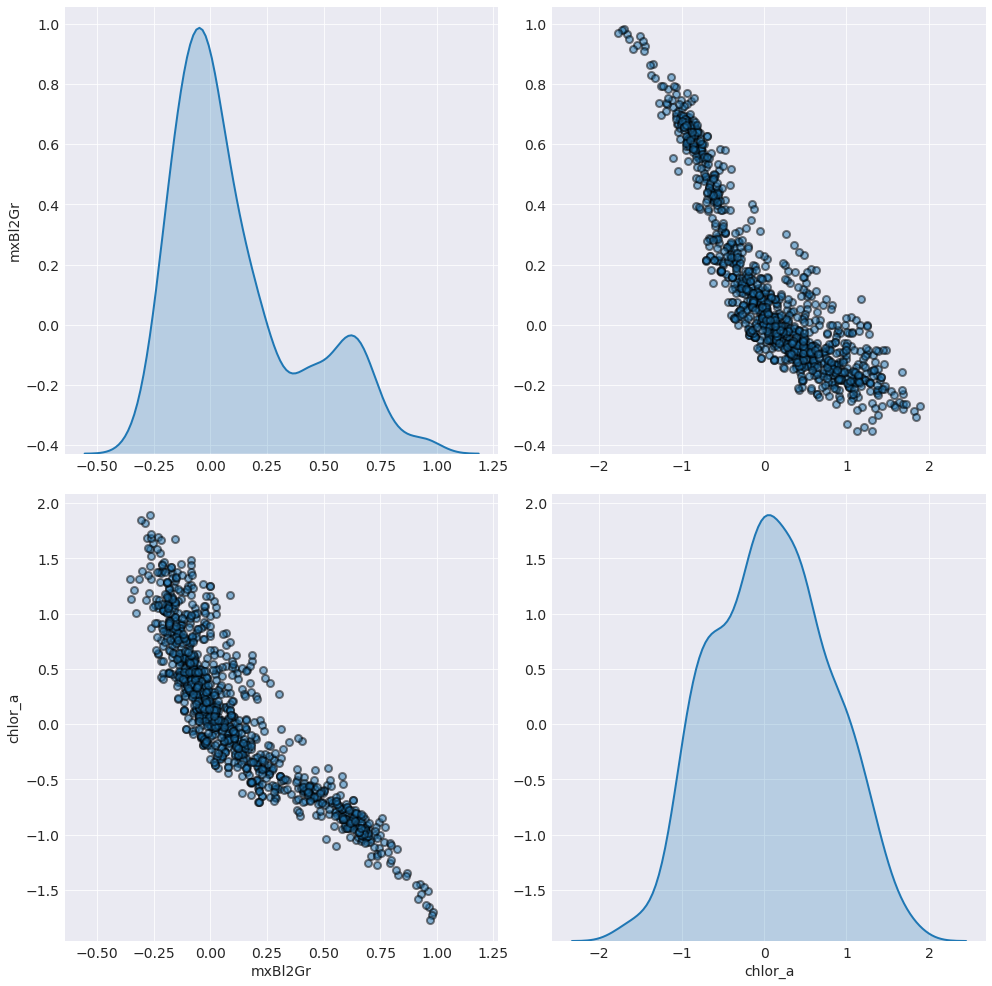

In [7]:
sb.pairplot(dfLogOC4.drop(['id', 'mxBlId'], axis=1), size=7, diag_kind="kde", markers="o",
                          plot_kws=dict(s=50, edgecolor="k", alpha=0.5,
                                        linewidth=2), diag_kws=dict(shade=True, linewidth=2));

Now I'm going to produce a first bayesian regression. I start by specifying flat (i.e. uninformative priors) on intercept and slopes. Priors encode what the practitioner knows *a-priori* about the underlying process - in this case, not much. Priors are often contentious for erroneous reasons. They should be looked upon as a vehicle for regularization and/or a way to bring context into the model. This ensures that the model doesn't get unduly excited by the often scant data it is fed.

Next is to specify the Likelihood. This part is the only bit that is common with a frequentist method. Whereas the frequentist to strive to maximize the likelihood of the data given a set of model coefficients - Likelihood Maximization, the bayesian uses it as an update mechanism of the stipulated priors.

Quick note on the code snippet below: the 'with' command with subsequent indentation forms a model context indicator, informing the interpreter what to access for a particular (related) task; in this case passing the model stipulation to the MCMC sampler in the code cell that follows.

In [27]:
mxBl2Gr = dfLogOC4.mxBl2Gr
with pm.Model() as m_oc4:
    # (flat) priors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=4)
    sigma_chl = pm.HalfNormal('sigma', sd=2)
    
    # likelihood:
    mu = alpha + beta[0] * mxBl2Gr + beta[1] * mxBl2Gr**2 + beta[2] * mxBl2Gr**3 + beta[3] * mxBl2Gr**4
    chlor_a_pred = pm.Normal('chlor_a_pred', mu=mu, sd=sigma_chl, observed=dfLogOC4.chlor_a)

Now I can sample the posteriors. By default, the sampler will run sample from as many indepent chains as there are cores available on my computer; in this case 4. This enables the practitioner to ensure that all chains look more or less alike; the contrary being an indication of a problem.
Specifying 5000 samples then means that there will be a total 20000 samples drawn.

In [28]:
with m_oc4:
    trace_oc4 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [00:50<00:00, 118.02it/s]


As a first diagnosis, plotting the posterior marginal distributions (left) and the corresponding traces (right) is very useful. The posterior marginals are simply the posterior distribution of each unobserved variable ($\alpha$, $\beta$, etc) after the other variables have been integrated out. In a high dimensional space such as the one resulting from the inference above, this enables plotting each distribution as a simple histogram, for visual evaluation.

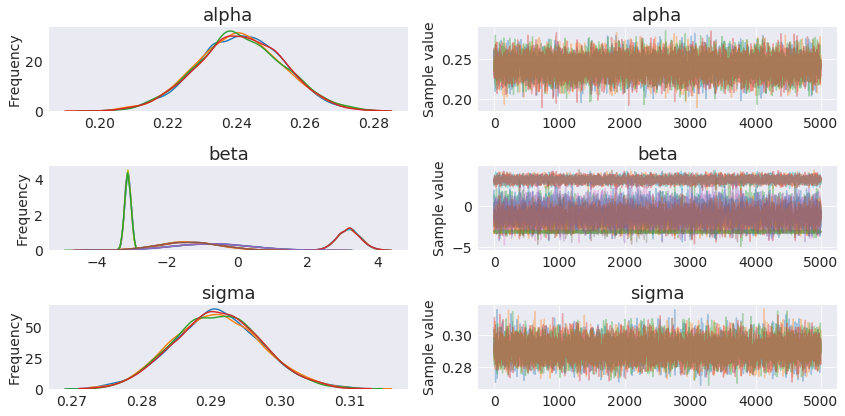

In [178]:
pm.traceplot(trace_oc4);

The traces (right) have no apparent autocorrelation, a sign of good health with the sampler used here (Hamiltonian Monte Carlo). However, two of the $\beta$s seem conspicuously flat (left middle panel). Moreover, they straddle '$0$', which may indicate a problem. To try to tease out what might have gone wrong, I will first plot for reference the posteriors, next to their priors; I will then examine the traces above in more detail; finally, I will plot the posterior pairwise to see if they relate to eachother in anyway to see if inference on one has hinder inference on the other.

First, histograms of priors and posteriors. Note here that to keep both priors and posteriors visible on the same graph without too much distortion, I set the priors to be $ \sim \mathcal{N}(\mu=0, sd=1)$ instead of $sd=10$ as in above. The real priors are much flatter, but the resulting priors would not change much (I've tried).

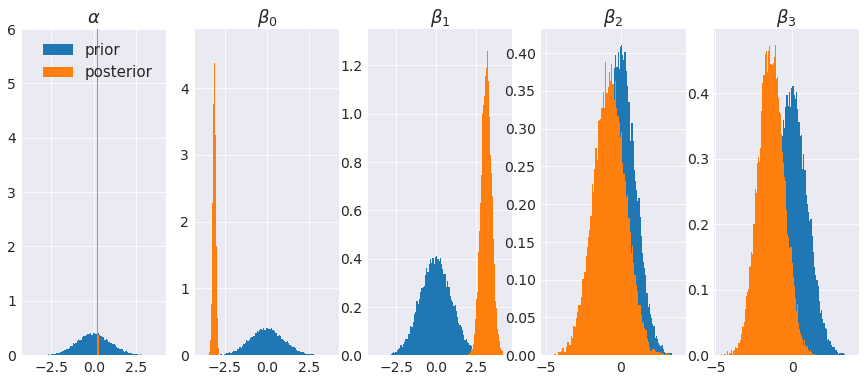

In [204]:
prior_alpha_beta =stats.norm.rvs(loc=0, scale=1, size=20000)
names=[r'$\alpha$', r'$\beta$']
posteriors_alpha_beta = np.c_[trace_oc4.get_values('alpha', combine=True), trace_oc4.get_values('beta', combine=True)]
_f, ax = pl.subplots(ncols=5, figsize=(15,6))
for i, axi in enumerate(ax.ravel()):
    if i ==5:
        break
    axi.hist(prior_alpha_beta, label='prior', normed=True, bins=100)
    axi.hist(posteriors_alpha_beta[:,i], label='posterior', normed=True, bins=100)
    if i == 0:
        axi.legend(fontsize=15);
        axi.set_title(r'$\alpha$')
        axi.set_ylim(0, 6)
    else:
        axi.set_title(r'$\beta_%d$' % (i-1))

Clearly, $\beta_2$ and $\beta_3$ have certainly tightened quite a bit but have not moded much beyond that.
Let's examine the traces in more detail:

In [31]:
pm.summary(trace_oc4, alpha=0.08)

,mean,sd,mc_error,hpd_4,hpd_96,n_eff,Rhat
alpha,0.241102,0.012736,0.000119,0.218180,0.262773,10858.0,1.000036
beta__0,-3.108250,0.090806,0.000864,-3.269019,-2.953965,9206.0,1.000064
beta__1,3.177766,0.329109,0.003714,2.586163,3.737996,8569.0,1.000043
beta__2,-0.763153,1.079461,0.012927,-2.628783,1.139636,6890.0,1.000121
beta__3,-1.383610,0.847282,0.009958,-2.832060,0.124269,7284.0,1.000184
sigma,0.291034,0.006376,0.000059,0.279957,0.302185,12361.0,0.999925


The 'Rhat' column in the table above features entries close to $1$, another indication of good convergence. However, in the case of $\beta_2$ and $\beta_3$, the effective sample size (n_eff) is quite low relative to the 20000 total samples drawn for each; further clue to a potential problem. I'll plot the marginal posteriors again in more details; this time with '0' lines drawn for reference.

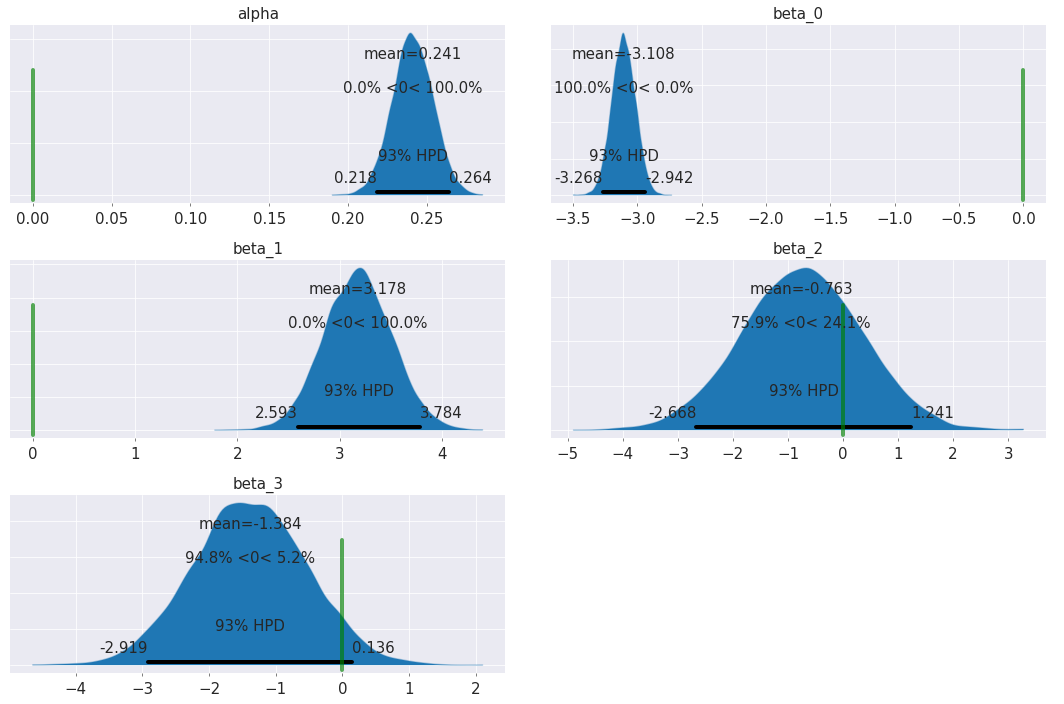

In [35]:
axs = pm.plot_posterior(trace_oc4, varnames=['alpha', 'beta'], ref_val=0, alpha_level=0.07,
                        kde_plot=True, shade=True, figsize=(15, 10));

Notice that the regression coefficients are different than those featured in the latest vanilla OC4, OC4v6, which can be seen [on the first line of this table](https://oceancolor.gsfc.nasa.gov/atbd/chlor_a/#sec_2), where $a_0$ corresponds to $\alpha$ and $a_{1..4}$ corresponds to $\beta_0..3$. My understanding is that some additional pre-processing of the data was done. But I'm not privy to the exact steps, so I'll ignore it. Otherwise, the mean of the coefficients above should be quite close to an ordinary least-squares regression. That said the bayesian posteriors, absent from OLS regression make for a rich source of information, for model evaluation, comparison, and critique. This is demonstrated below.

Next is to examine pairwise relationships between marginal posteriors.

In [287]:
df_toc4 = pm.trace_to_dataframe(trace_oc4, varnames=['alpha', 'beta'])

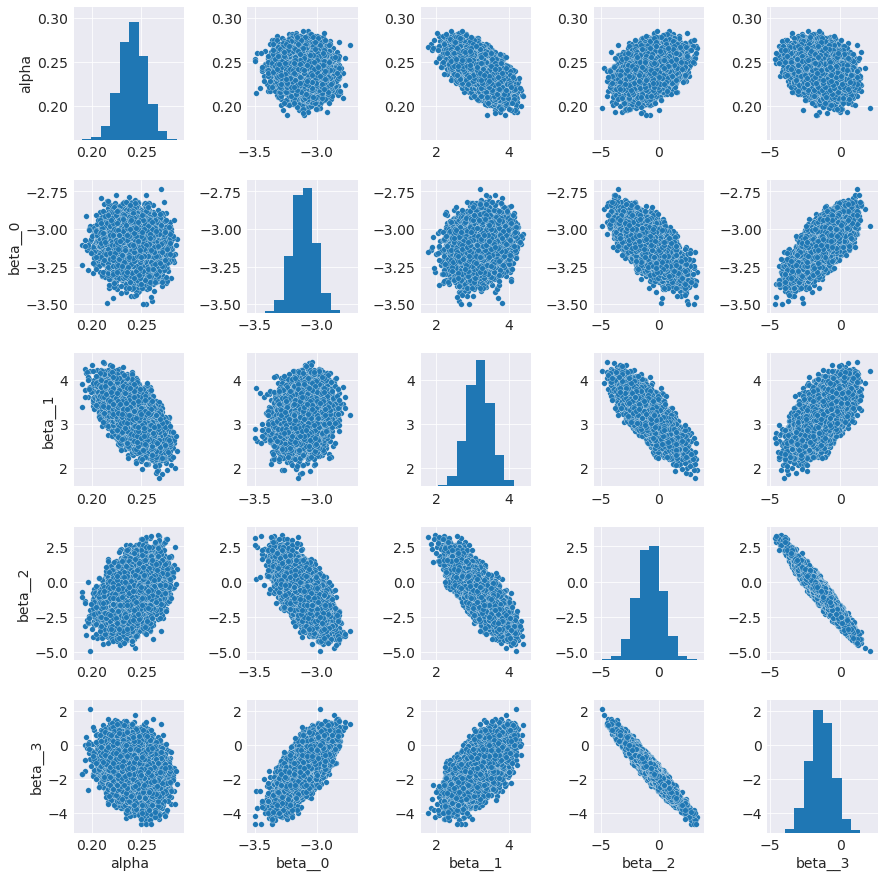

In [45]:
sb.pairplot(data=df_toc4);

So $\beta_2$ and $\beta_3$ do not seem to add much to the inference. Because an unnecessarily complicated model often leads to overfitting (i.e. fits well the training data but does a poor job on subsequent out-of-sample data), one would naturally tend to simplify the model. Next I use the following model as the likelihood and proceed to compare the two: 
$$ log_{10}\left(chlor\_a\right) = \alpha + \sum_{i=1}^{3}\beta_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

In [52]:
with pm.Model() as m_oc4_3:
    # (flat) priors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma_chl = pm.HalfNormal('sigma', sd=2)
    
    # likelihood:
    mu = alpha + beta[0] * mxBl2Gr + beta[1] * mxBl2Gr**2 + beta[2] * mxBl2Gr**3
    chlor_a_pred = pm.Normal('chlor_a_pred', mu=mu, sd=sigma_chl, observed=dfLogOC4.chlor_a)

In [53]:
with m_oc4_3:
    trace_oc4_3 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [00:16<00:00, 353.74it/s]


In [48]:
pm.summary(trace_oc4_3,alpha=0.08)

,mean,sd,mc_error,hpd_4,hpd_96,n_eff,Rhat
alpha,0.235875,0.012244,0.000099,0.214445,0.257168,9923.0,1.000048
beta__0,-3.002626,0.063422,0.000582,-3.111076,-2.889787,11395.0,0.999931
beta__1,3.495770,0.262812,0.002995,3.042659,3.957895,6737.0,1.000046
beta__2,-2.452509,0.294791,0.003095,-2.949867,-1.917256,7895.0,1.000106
sigma,0.291299,0.006402,0.000046,0.280108,0.302533,16729.0,1.000073


Rhat suggests good convergence also. Moreover the highest posterior density columns (hpd) suggest no 0-straddling, which is encouraging. Once again, however, the problem of low n_eff is present; this time for $\beta_1$ and $\beta_2$. Once more, examining pairwise relationships can be revealing:

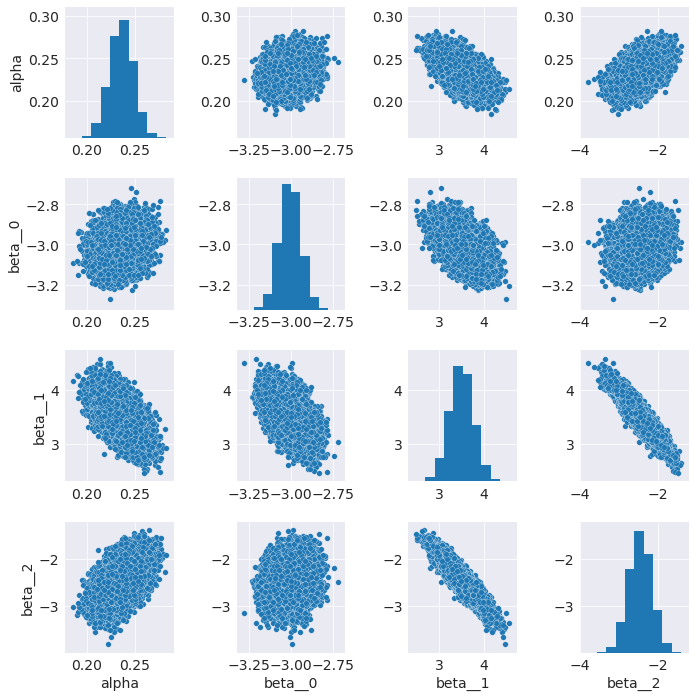

In [177]:
df_toc4_3 = pm.trace_to_dataframe(trace_oc4_3, varnames=['alpha', 'beta'])
sb.pairplot(df_toc4_3);

And again, two of the slope coefficients $\beta_1$ and $\beta_2$ track each other, seemingly adding very little information. At this point, this may be suggesting a problem with the model structure itself. As mentioned before a high-order polynomial regression can be problematic. The only improvement in this instance is that, as seen below, none of the posterior marginals overlaps the '$0$' line.

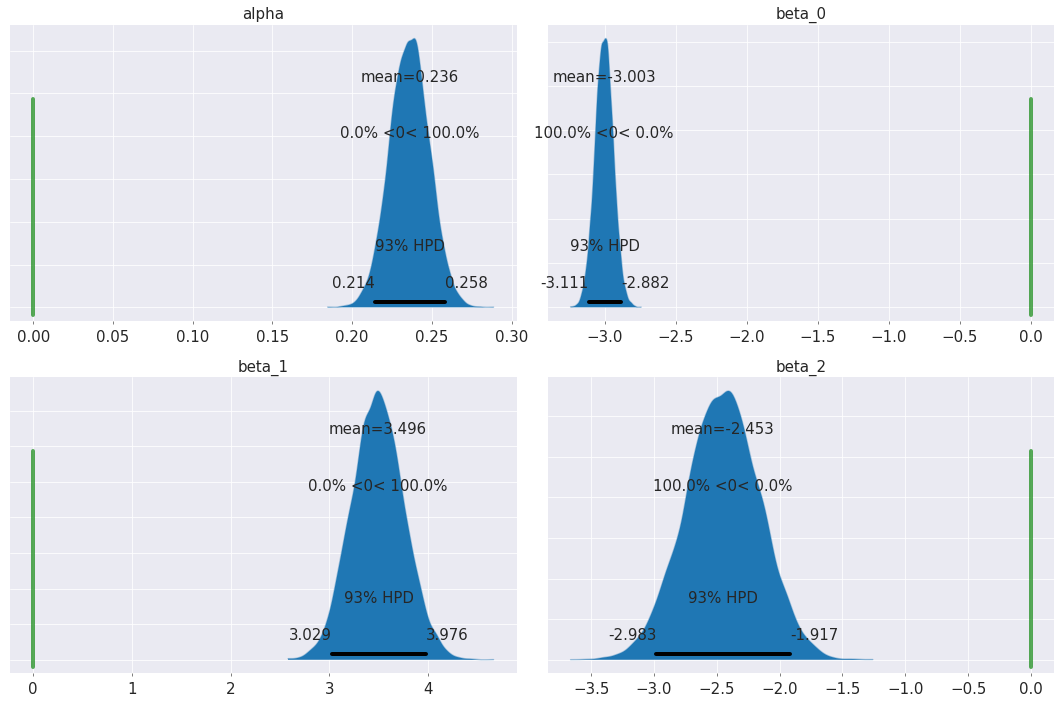

In [51]:
axs = pm.plot_posterior(trace_oc4_3, varnames=['alpha', 'beta'],
                        ref_val=0, alpha_level=0.07, kde_plot=True, shade=True, figsize=(15, 10));

Next is to compare models and assess uncertainties.

### Model Posteriors and Uncertainty

Step:
* create a mock max(blue)/green dataset, $x$ in the code below, ranging a little outside of the observed data, on either side
* compute posterior (deterministic) chlor_a distribution at each $x_i$
* get credibility interval around mean chlor_a along $x$ 

First to create $x$:

In [160]:
x = np.linspace(-0.45, 1.3, 100).reshape(-1, 1)

Now to compute modeled chlor_a distribution at each $x_i$. I first write a function to avoid duplicating code.

In [246]:
def get_modeled_y(trace, x):
    mu_y = np.zeros((len(x), len(trace) * trace.nchains))
    for i, xi in enumerate(x):
        mu_y[i] = trace['alpha'] # add intercept
        for j in range(trace['beta'].shape[1]):
            xi_ = xi **(j+1)
            mu_y[i] += xi_ * trace['beta'][:, j]
    return mu_y

Get modeled data distributions...

In [ ]:
mu_oc4 = get_modeled_y(trace_oc4, x)
mu_oc4_3 = get_modeled_y(trace_oc4, x)

Compute model stats...

In [283]:
# compute model stats
def get_model_stats(mu_y):
    mu_y_med = np.median(mu_y, axis=1)
    mu_y_hpd = pm.hpd(mu_y.T)
    return mu_y_med, mu_y_hpd

mu_oc4_med, mu_oc4_hpd = get_model_stats(mu_oc4)
mu_oc4_3_med, mu_oc4_3_hpd = get_model_stats(mu_oc4_3)

Plot results:

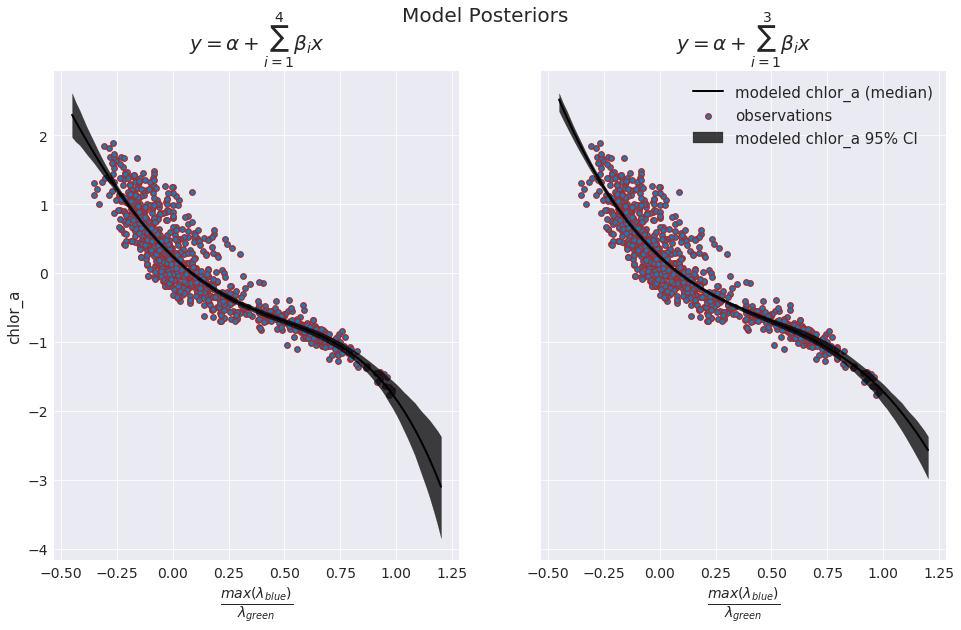

In [284]:
f, axs = pl.subplots(ncols=2, figsize=(16, 9), sharey=True)
f.suptitle('Model Posteriors', fontsize=20)
axs[0].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, edgecolor='brown', linewidth=1.2)
axs[0].plot(x, mu_oc4_med, color='k', lw=2)
axs[0].set_xlabel('$x$', fontsize=18)
axs[0].set_ylabel('chlor_a', fontsize=15)
axs[0].set_xlabel(r'$\frac{ max( \lambda_{blue} ) }{\lambda_{green}}$', fontsize=20)
axs[0].set_title(r'$y = \alpha + \sum_{i=1}^4\beta_ix$', fontsize=20, y=1.03 )
axs[0].fill_between(x.ravel(), mu_oc4_hpd[:, 0], mu_oc4_hpd[:, 1], color='k', alpha=0.75)
axs[1].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, edgecolor='brown', linewidth=1.2, label='observations')
axs[1].plot(x, mu_oc4_3_med, color='k', lw=2, label='modeled chlor_a (median)')
axs[1].fill_between(x.ravel(), mu_oc4_3_hpd[:, 0], mu_oc4_hpd[:, 1], color='k', alpha=0.75, label='modeled chlor_a 95% CI')
axs[1].set_xlabel('$x$', fontsize=18)
axs[1].set_xlabel(r'$\frac{max(\lambda_{blue})} {\lambda_{green}}$', fontsize=20)
axs[1].set_title(r'$y = \alpha + \sum_{i=1}^3\beta_ix$', fontsize=20, y=1.03)
axs[1].legend(fontsize=15);

The 95% credibility interval around mean predicted chlorophyll are quite tight. How then to explain the spread in the data?
This happens because there is not much ambiguity around the *expected chlor_a* at a given input value because the modeled chlor_a is deterministic.  
The key to exploring chlorophyll as a probabilistic construct conditioned on input $\frac{max(\lambda_{blue})} {\lambda_{green}}$
is the **<u>posterior predictive</u>**.


### Future Data Simulation and the Posterior Predictive
* Bayesian models are generative.
* This means that they enable simulation of future data $\rightarrow$ <u>posterior predictives</u>
* Posterior predictives: distribution of unobserved events ($chlor\_a_{new}$) conditioned on previous observations, after the $\alpha$ and $\beta$s have been marginalized over all possible values:
$$ p(chlor\_a_{new}\mid chlor\_a_{observed}) = \int\int p(chlor\_a_{new}\mid \alpha,\beta)\ p(\alpha,\beta \mid chlor\_a_{observed})\ d\alpha\ d\beta$$

The library I use, PyMC3, makes it easy to sample from the posterior predictives. Below I do that for both models

In [56]:
ppc_oc4 = pm.sample_ppc(trace_oc4, 1000, m_oc4, )['chlor_a_pred'] # posterior predictive for m_oc4
ppc_oc4_3 = pm.sample_ppc(trace_oc4_3, 1000, m_oc4_3)['chlor_a_pred'] # posterior predictive for m_oc4_3
hpd_95_ppc_oc4 = pm.hpd(ppc_oc4) # 95% credibility interval for ppc_oc4
hpd_95_ppc_oc4_3 = pm.hpd(ppc_oc4_3) # 95% credibility interval for ppc_oc4_3
med_ppc_oc4 = np.median(ppc_oc4, axis=0)
med_ppc_oc4_3 = np.median(ppc_oc4_3, axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]


Next is to plot the posterior predictives along with the trainig dataset, for both models. Because these are distributions of as yet unobserved data, the resulting intervals are quite a bit larger. They also represent an estimate of where there is a, in this case, 95% chance that a future data point will be observed.

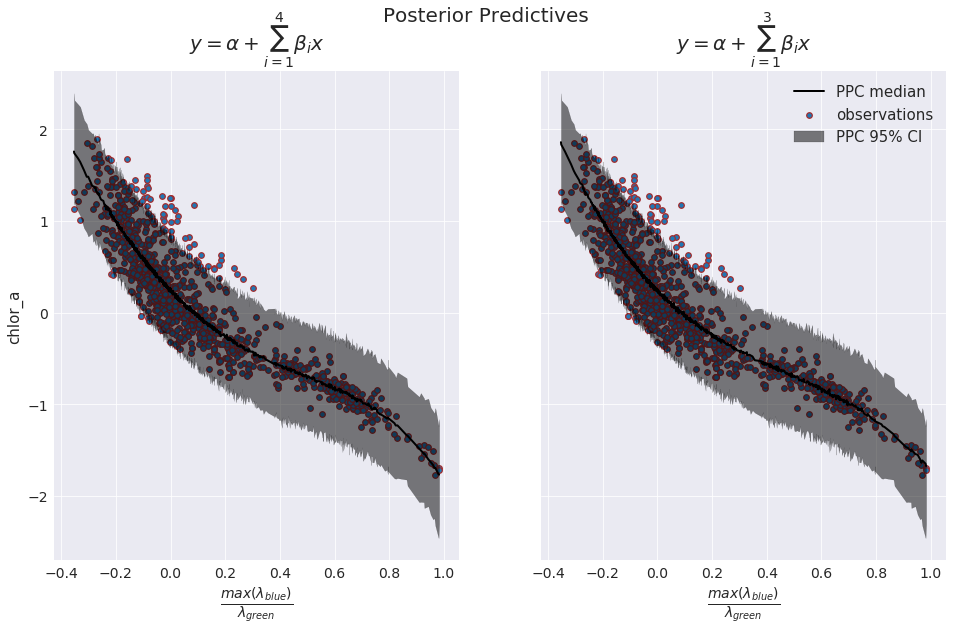

In [110]:
f, axs = pl.subplots(ncols=2, figsize=(16, 9), sharey=True)
f.suptitle('Posterior Predictives', fontsize=20)
ix=np.argsort(dfLogOC4.mxBl2Gr)
axs[0].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, edgecolor='brown', linewidth=1.2)
axs[0].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4[ix], color='k', lw=2)
axs[0].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4[ix,0], hpd_95_ppc_oc4[ix, 1], alpha=0.5, color='k')
axs[0].set_ylabel('chlor_a', fontsize=15)
axs[0].set_xlabel(r'$\frac{ max( \lambda_{blue} ) }{\lambda_{green}}$', fontsize=20)
axs[0].set_title(r'$y = \alpha + \sum_{i=1}^4\beta_ix$', fontsize=20, y=1.03 )
axs[1].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, label='observations', edgecolor='brown', linewidth=1.2)
axs[1].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4_3[ix], color='k', label='PPC median', lw=2)
axs[1].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4[ix,0], hpd_95_ppc_oc4[ix, 1], alpha=0.5, color='k',
                   label='PPC 95% CI')
axs[1].set_xlabel(r'$\frac{max(\lambda_{blue})} {\lambda_{green}}$', fontsize=20)
axs[1].set_title(r'$y = \alpha + \sum_{i=1}^3\beta_ix$', fontsize=20, y=1.03)
axs[1].legend(fontsize=15);

### Information Theoretic Assessment of Future Performance

One popular way of comparing models is the Widely Available Information Criterion. The name is indicative of Watanabe's humor, since as the inventor of the metric, he could have gone with the more flattering and perhaps more informative Watanabe Akaike Information Criterion label. The fact remains that this is a very versatile construct; bayesian in nature by its virtue of using the full posterior distribution, in addition to penalizing model complexity much like its frequentist cousin, the AIC.

It is based on a clever trick of pairwise subtracting Kullback-Leibler divergences, each of which specifies the divergence  between the model posterior and the never observed *true posterior*. The distribution of the true posterior drops out, leaving just pairwise deviances between the models themselves. 

WAIC is made of two parts, a pointwise computation of the likelihood of the N data points of the training dataset conditioned on the posterior ($lppd$ for *log pointwise predictive density*) and the effective number of parameters ($p_{waic}$), reminiscent of the better known AIC. $p_{waic}$ is computed by the summing the variances of the log likelihood of each observation. In summary:

$$ WAIC = -2( lppd - p_{waic})$$
with,
$$lppd = \sum_{i=1}^N log(y_i \mid \theta_{post})$$
where $\theta_{post}$ is the posterior distribution of model coefficients (unobserved variables $\alpha$ and $\beta$s in the present case), and, 
$$p_{waic} = \sum_{i=1}^N V(y_i)$$
where $V(y_i)$ is the variance of observation $i$.
 

Below, I create a dataframe based on WAIC, designed to help the practitioner make some decisions on how best to use the models. Models are sorted by decreasing performance (increasing WAIC).

In [206]:
models = [m_oc4, m_oc4_3]
traces = [trace_oc4, trace_oc4_3]
mdl_names = ['m_oc4', 'm_oc4_3']
df_comp = pm.compare(traces=traces, models=models)
df_comp.index = [mdl_names[i] for i in df_comp.index]
df_comp

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
m_oc4,379.52,5.56,0,0.66,56.46,0,1
m_oc4_3,380.38,4.76,0.86,0.34,56.6,3.19,1


So overall, the $4^{th}$ degree polynomial is expected to do marginally better. However the WAICs are quite close and the associated 'weight' of the top model is far from *$1$*. This suggests that better performance can be expected from combining both models. Model combination is done using the weights, *cf.* table above, which constitute a probabilistic assessment of model performance on future data. Weights and corresponding models are combined by ensemble averaging, where each weight informs the influence of the corresponding model. I'll demonstrate this in a subsequent post.
First I'm going to load out-of-sample data spanning the years 2008-2010, i.e. outside the data used to fit the model with the latest record dating back to 2007:

In [211]:
dfNomadV2.datetime.dt.year.max()

2007

Now to load and shape the test set obtained from [SeaBASS](https://seabass.gsfc.nasa.gov/).

In [218]:
df_test_raw = pd.read_pickle('./pickleJar/SwfTestCl.pkl')
df_test_raw.head(2).T

,0,1
id,280136,279946
latitude,29.0527,23.0139
longitude,-87.3232,59.9755
date_time,2010-05-13 21:02:00,2010-03-10 11:37:00
cruise,2010_05_wbii,abudhabi-masqat
seawifs_filename,S2010133195617.L2_MLAC.R0000020308_2010_05_wbi...,S2010069095904.L2_GAC.R0000020316_abudhabi-mas...
seawifs_es_error,0,0
seawifs_pixel_total,25,25
seawifs_tdiff,-2866,-5159
seawifs_solz,35.43,40.02


In the next few code cells, I'll create the test set.

In [276]:
# convert date_time entries to python datetime objects for easy manipulation.
df_test_raw['date_time'] = pd.to_datetime(df_test_raw.date_time)

In [277]:
df_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 116
Data columns (total 21 columns):
id                     97 non-null int64
latitude               97 non-null float64
longitude              97 non-null float64
date_time              97 non-null datetime64[ns]
cruise                 97 non-null object
seawifs_filename       97 non-null object
seawifs_es_error       97 non-null float64
seawifs_pixel_total    97 non-null int64
seawifs_tdiff          97 non-null int64
seawifs_solz           97 non-null float64
seawifs_senz           97 non-null float64
seawifs_cv             97 non-null float64
seawifs_windspeed      97 non-null float64
seawifs_chlor_a        97 non-null float64
insitu_chlor_a         97 non-null float64
seawifs_rrs412         97 non-null float64
seawifs_rrs443         97 non-null float64
seawifs_rrs490         97 non-null float64
seawifs_rrs510         97 non-null float64
seawifs_rrs555         97 non-null float64
seawifs_rrs670         97 non-null fl

In [279]:
# check the data is indeed out-of-sample:
bound_years = df_test_raw.date_time.dt.year.min(), df_test_raw.date_time.dt.year.max()
print(f'test dataset bounding years: {bound_years[0]} - {bound_years[1]}')

test dataset bounding years: 2008 - 2010


In [267]:
# Create test data set in the image of the training data set:
df_test = df_test_raw.filter(regex='rrs')
df_test.insert(df_test.shape[1], 'swf_chlor_a', df_test_raw.seawifs_chlor_a)
df_test.insert(df_test.shape[1], 'is_chlor_a', df_test_raw.insitu_chlor_a)

# shorten rrs column_names
ren_cols = df_test.filter(regex='rrs').columns.tolist()
df_test = df_test.rename(columns={col: col.split('_')[1] for col in ren_cols})

df_test.insert(0, 'id', df_test_raw.id)
df_test.insert(df_test.shape[1]-2, 'maxBlue', df_test[['rrs443','rrs490','rrs510']].max(axis=1))
df_test.insert(df_test.shape[1]-2, 'mxBl2Gr', df_test.maxBlue / df_test.rrs555)
df_test.head()

In [270]:
dfLogOC4_test = pd.concat((df_test[['id']], np.log(df_test[['mxBl2Gr', 'swf_chlor_a', 'is_chlor_a']])), axis=1)

Now that I have a test set, I will quickly examine it to make sure all seems fine.

In [271]:
dfLogOC4_test.head()

,id,mxBl2Gr,swf_chlor_a,is_chlor_a
0,280136,1.149155,-1.610183,-1.750138
1,279946,-0.055379,0.965366,0.294161
2,279960,1.154846,-1.562602,-2.137071
3,293134,-0.355604,2.015094,0.183213
4,279633,-0.100566,1.017428,0.555608


In [273]:
dfLogOC4_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 116
Data columns (total 4 columns):
id             97 non-null int64
mxBl2Gr        97 non-null float64
swf_chlor_a    97 non-null float64
is_chlor_a     97 non-null float64
dtypes: float64(3), int64(1)
memory usage: 3.8 KB


Next is to create modeled chlorophyll from the test set and plot along side the inference results from earlier:

In [281]:
mod_chl_test_oc4 = get_modeled_y(trace_oc4, dfLogOC4_test.mxBl2Gr.values)
mod_chl_test_oc4_3 = get_modeled_y(trace_oc4_3, dfLogOC4_test.mxBl2Gr.values)

In [285]:
# get modeled chl stats for test data:
chl_test_oc4_med, _ = get_model_stats(mod_chl_test_oc4)
chl_test_oc4_3_med, _ = get_model_stats(mod_chl_test_oc4_3)

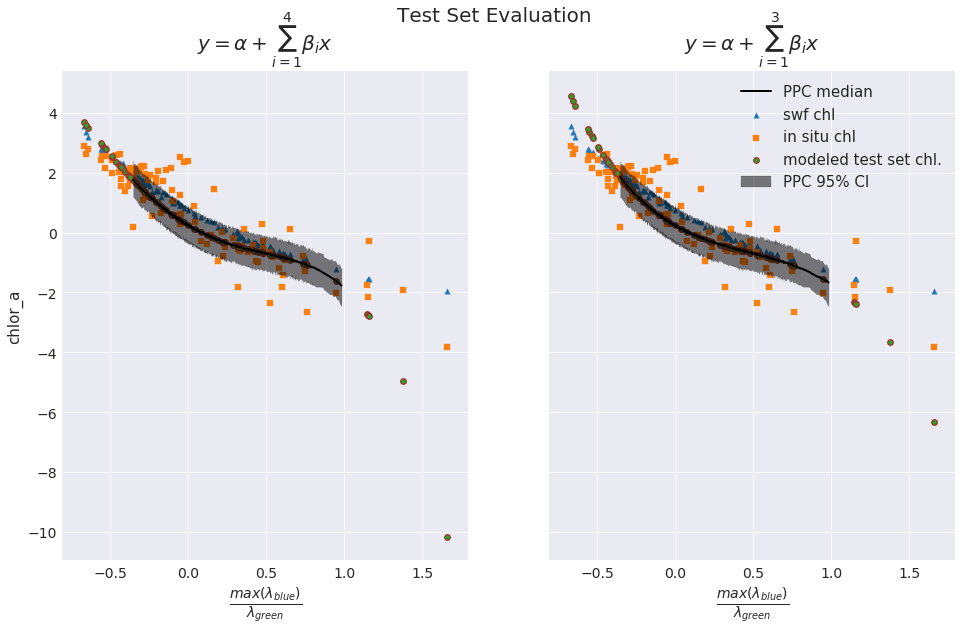

In [290]:
f, axs = pl.subplots(ncols=2, figsize=(16, 9), sharey=True)
f.suptitle('Test Set Evaluation', fontsize=20)
ix=np.argsort(dfLogOC4.mxBl2Gr)
#axs[0].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, edgecolor='brown', linewidth=1.2)
axs[0].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.swf_chlor_a, marker='^')
axs[0].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.is_chlor_a, marker='s')
axs[0].scatter(dfLogOC4_test.mxBl2Gr, chl_test_oc4_med, edgecolor='brown', linewidth=1.2)
axs[0].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4[ix], color='k', lw=2)
axs[0].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4[ix,0], hpd_95_ppc_oc4[ix, 1], alpha=0.5, color='k')
axs[0].set_ylabel('chlor_a', fontsize=15)
axs[0].set_xlabel(r'$\frac{ max( \lambda_{blue} ) }{\lambda_{green}}$', fontsize=20)
axs[0].set_title(r'$y = \alpha + \sum_{i=1}^4\beta_ix$', fontsize=20, y=1.03 )
#axs[1].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, label='observations', edgecolor='brown', linewidth=1.2)
axs[1].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.swf_chlor_a, marker='^', label='swf chl')
axs[1].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.is_chlor_a, marker='s', label='in situ chl')
axs[1].scatter(dfLogOC4_test.mxBl2Gr, chl_test_oc4_3_med, edgecolor='brown', linewidth=1.2,
               label='modeled test set chl.')
axs[1].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4_3[ix], color='k', label='PPC median', lw=2)
axs[1].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4[ix,0], hpd_95_ppc_oc4[ix, 1], alpha=0.5, color='k',
                   label='PPC 95% CI')
axs[1].set_xlabel(r'$\frac{max(\lambda_{blue})} {\lambda_{green}}$', fontsize=20)
axs[1].set_title(r'$y = \alpha + \sum_{i=1}^3\beta_ix$', fontsize=20, y=1.03)
axs[1].legend(fontsize=15);

A number of observations can be made from the plot above:
    * quite a bit of the data is outside the range of the training data set. This paucity is a problem for developing good models. This is also a good reason for adopting bayesian methods because they are better suited for dealing with scant or incomplete data. 
    * field data is much noisier than satellite data
        - satellite chl. come from a regression similar to the average of the model produced here
        - satellite data are averages of the area corresponding to the sampling station
        - in situ samples are point measurements of potentially transient processes
    * the 4th order polynomial deals better with high-chlorophyll samples
    * the 3rd order polynomial handles the low chlorophyll values better

Note that there is no need to choose a model, in particular given the WAIC weights estimated above. Ensemble averaging using these weights is possible and in fact recommended. I will demonstrate this in subsequent posts after I've developed a few more models.

Finally, I serialize models, traces and datasets so that these are available, without using too much disk space. In particular the models can be used for production purposes or for comparison with other models developed in subsequent posts.

In [289]:
with open('./pickleJar/models', 'wb') as fmod:
    mod_dict = dict(models=dict(oc4=m_oc4,oc4_3=m_oc4_3),
                     traces=dict(oc4=trace_oc4, oc4_3=trace_oc4_3)
                    )
    pickle.dump(mod_dict, fmod)
with open('./pickleJar/datasets', 'wb') as fdat:
    dataset_dict = dict(swf=dict(train=dfLogOC4, test=dfLogOC4_test))
    pickle.dump(dataset_dict, fdat)

Steps forward:

    1 - ensemble averaging, particularly after experimenting with a few more models. A WAIC analysis can then yield Akaike weights that can be used to weight each model's contribution.
    2 - there are some obvious clustering information available in the original NOMAD data set. The conventional approach, also used here, of pooling all available data to obtain a single set of regression coefficients can result in significant information loss. The next post will detail development of bayesian generalized linear models that use these clusters.
    3 - the data set used for training is inadequate, a discussion of how to incorporate more data is required; particularly because bayesian modeling can offer mitigating mechanisms for subpar data that may nevertheless contain usable information.
    4 - high-order polynomial regression is generally a bad idea, as the inherent multicollinearity hinders the inference. Alternative formulations should be pursued. These will be the subject of a subsequent post.